## Evaluation of energy savings by using intermittent heating/cooling of dwellings
This notebook describes the code utilized for the research project report "Evaluation of energy savings by using intermittent heating/cooling of dwellings". The code describes a thermal circuit utlizing matrices and vectors. The circuit is transformed into a system of differential algebraic equations which are then transformed into a state-space-representation. In this notebook, the method and code is briefly explained. The code is based off of previous work wiht the dm4bem method and detailed explanations can be found at https://cghiaus.github.io/dm4bem_book

## 1.  Description of the model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf

Firstly, the dimensions of the modeled building are defined. The walls, the window, and the relation between the window and wall surface areas.

In [12]:
# %% INPUTS

# Wall dimensions
l = 4  # length of wall
Sf = 8   # surface area of concrete/glass wall (glass part)
Sc_1 = Si_1 = l**2 - Sf  # surface area of concrete/glass wall (concrete part)

Sc = Si = 5 * l**2  # surface area of all other full concrete/insulation walls

# Sf/Sc_1 # fenestration / wall ratio of wall 1

## 2. Thermo-physical properties
The thermophysical properties of the wall and window components are: 

In [15]:

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}                  # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si}                # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': Sf}                     # m²

# wall that is partly glass:
concrete_1 = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc_1}                # m²

insulation_1 = {'Conductivity': 0.027,      # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si_1}              # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Layer_out_1': concrete_1,
                               'Layer_in_1': insulation_1},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,80
Layer_in,0.027,55.0,1210,0.08,80
Glass,1.400,2500.0,1210,0.04,8
Layer_out_1,1.400,2300.0,880,0.20,8
Layer_in_1,0.027,55.0,1210,0.08,8


The thermophysical properties for air are also defined, as well as the properties of the ventilaion as well as the convection coefficients for indoor and outdoor conveciton: 

In [18]:
# physical properties of air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# surface convection coefficients 
h = pd.DataFrame([{'in': 10., 'out': 20}], index=['h'])  # W/(m²⋅K)
h

,in,out
h,10.0,20


## 3. Radiative properties 
The radiative properties are: 

In [21]:
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

## 4. Calculation of conductances
The following cell presents the formulas for calculating the conductances in the thermal circuit. The previously created dataframe is used to implement the material properties and calculate the conduction of walls and window. The convection coefficients are used to calculate heat transfer by convection in some nodes. 

In [24]:
# %% CONDUCTANCES

# calculates the conduction using all rows and columns in the dataframe
# creates another column which is conductances
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])


# %% CONVECTION

# formulas for convection, does not calculate yet
Gw = h * wall['Surface'].iloc[0]     # walls 100% concrete/insulation
Gg = h * wall['Surface'].iloc[2]     # glass
Gw_1 = h * wall['Surface'].iloc[3]  # concrete part of glass wall

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

In order to calculate radiative heat exchange, the view factor between window and wall is calculated. Thereafter the conductance for the radiative long-wave heat exchange can be calculated. 

In [27]:
# %% VIEW FACTORS GLASS / OTHER WALLS

Fwg = glass['Surface'] / concrete['Surface']

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

# WHICH MAKES THE CONDUCTANCE FOR THE HEAT EXCHANGE: (q 5)
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot  # q 10 ventilation

## 5. Thermal capacities
The thermal capacity of te walls and the air are calculated as: 

In [30]:

# walls
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

# air
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

,Capacity
Layer_out,32384000.0
Layer_in,425920.0
Glass,968000.0
Layer_out_1,3238400.0
Layer_in_1,42592.0
Air,76800.0


## 6. Creation of matrices and vectors 
In order to calculate the flows and temperature of the model. The thermal circuit is described as a system of algebraic-differential equtions which is constructed by a set of matrices and vectors

## 6.1. Temperature nodes and flow-rate branches
The constructed thermal circuit consists of 12 temperature nodes and 17 flow-rate branches. 

In [34]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11']
nθ = 12
θ = [f'θ{i}' for i in range(12)]

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13, q14', 'q15', 'q16']
nq = 17
q = [f'q{i}' for i in range(17)]

## 6.2. Incidence matrix A
The incidence matrix has a number of rows equal to the amount of flow-rate branches, and a number of columns equal to the number of temperature nodes.

If flow m enters into node n, then the element (m,n) of the matrix A is 1.
If flow m exits from node n, then the element (m,n) of the matrix A is -1.
The incidence matrix for the studied thermal circuit is constructed as: 

In [37]:
A = np.zeros([17, 12])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

A[12, 5], A[12, 8] = 1, -1  # branch 12: node 8 -> node 5
A[13, 8], A[13, 9] = 1, -1  # branch 13: node 9 -> node 8
A[14, 9], A[14, 10] = 1, -1  # branch 14: node 10 -> node 9
A[15, 10], A[15, 11] = 1, -1  # branch 15: node 11 -> node 10
A[16, 11] = 1                # branch 16: -> node 11

pd.DataFrame(A, index=q, columns=θ)
# print(A)

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9,θ10,θ11
q0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q5,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
q6,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
q7,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0
q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
q9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0


## 6.3 Conductance matrix G
The conductance matrix is diagonal, and consists of the previously calculated conductances arranged to correspond the afflicted nodes and branches.

In [40]:
G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp,
     2 * G_cd['Layer_in_1'], 2 * G_cd['Layer_in_1'],
     2 * G_cd['Layer_out_1'], 2 * G_cd['Layer_out_1'],
     Gw_1['out']]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

,0
q0,1600.000000
q1,1120.000000
q2,1120.000000
q3,54.000000
q4,54.000000
q5,40.432909
q6,800.000000
q7,80.000000
q8,124.444444
q9,560.000000


## 6.4 Capacity matrix
The capacity matrix is also diagonal and the thermal capacities of the air and of the glass can be neglected or not.

In [43]:
neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0, C['Layer_in_1'], 0, C['Layer_out_1'], 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass'], C['Layer_in_1'], 0, C['Layer_out_1'], 0])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

,0
θ0,0.0
θ1,32384000.0
θ2,0.0
θ3,425920.0
θ4,0.0
θ5,0.0
θ6,76800.0
θ7,968000.0
θ8,42592.0
θ9,0.0


## 6.5 Vectors
The temperature sources and flow-rates are arranged into vectors, where the temperature source vector b is of the same size as the number of branches. The flow-source vector is of the same size as the number of temperature nodes. An output vector, y, is also created which indicates the temperature node to be studied, in this case node 6 which corresponds to the inside air temperature.  

In [46]:
# %% temperature source vector (same amount as branches)

b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp', 0, 0, 0, 0, 'To'],
              index=q)

# flow source vector - lenght as nodes.
f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa', 0, 0, 0, 'Φo'],
              index=θ)

#% % output vector 
y = np.zeros(12)         # number of nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

,0
θ0,0.0
θ1,0.0
θ2,0.0
θ3,0.0
θ4,0.0
θ5,0.0
θ6,1.0
θ7,0.0
θ8,0.0
θ9,0.0


## 6.6 Creation of dataframe and assembling of thermal circuit
The created matrices and vectors are assembled into a thermal circuit and transformed into the state-space representation. 

In [49]:
# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
# TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

# state space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
us
print(us)

q0        To
q8        To
q10       To
q11    Ti_sp
q16       To
θ0        Φo
θ4        Φi
θ6        Qa
θ7        Φa
θ11       Φo
dtype: object


## 7. Test of steady state
The model is run in steady-state for validation. 

In [52]:
bss = np.zeros(17)        # temperature sources b for steady state
bss[[0, 8, 10, 16]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(12)         # flow-rate sources f for steady state
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

# test of steady state - OK all 10 degrees
θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

θss = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.] °C


## 8. Eigenvalues and timestep
In order to evaluate the model response to temperature, the eigenvalues of matrix A are calculated. The timestep, settling time and duration are also calculated. 

In [55]:
λ = np.linalg.eig(As)[0]
Δtmax = 2 * min(-1./λ)
dm4bem.print_rounded_time('Δtmax', Δtmax)

dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1/ λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

tau = -1/λ  # time constant
print(tau)

Δtmax = 885 s = 14.8 min
dt = 600 s = 10.0 min
t_settle = 192310 s = 53.4 h
duration = 194400 s = 54.0 h
[  442.80935179  3851.56350799  4293.64834209  7477.58949611
 48077.55147644 47452.29664406]


The following inputs are also needed:

In [58]:
# %% Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_proj = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_proj)

# %%
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)    # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)    # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

The timestep can thereafter be plotted: 

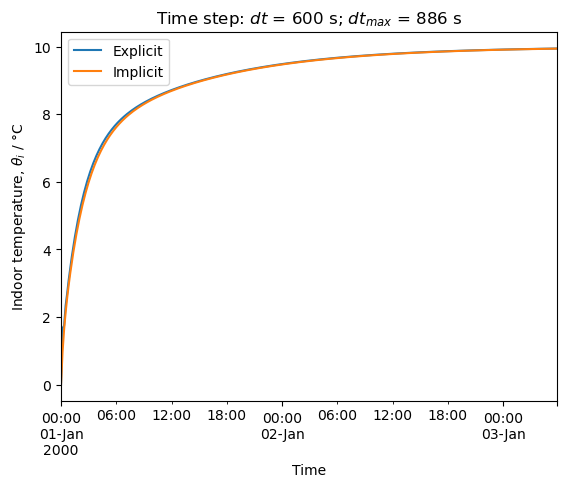

In [61]:
# %% plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()

## 9. Weather data and temperature sources
In order to evaluate the models dynamic response over a year, weatherdata is collected from energyplus and read into the model. 

In [66]:
# %% import weather data
start_date = '01-01 00:00:00'
end_date = '12-31 23:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')


filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]


2000-01-01 00:00:00 	start date
2000-12-31 23:00:00 	end date


## 9.1 Solar radiaiton
The temperature sources for outside temperature are read from the weatherfile. The solar radiation absorbed by the wall and window are calculated by reading the csv file wall_out. 

In [69]:
# Temperature sources
To = weather['temp_air']

# total solar irradiance
wall_out = pd.read_csv('walls_out.csv')  
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])
Etot = rad_surf.sum(axis=1)  # total solar irradience on walls

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot

# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g = Sf      # m², surface area of glass

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot

## 9.2. Set-points and input dataframe
The indoor air temperature set-point is defined, as well as the setback schedule for nighttime. The auxiliary sources are set to 0. Lastly, all temperature and flow rate soruces are loaded into the csv file input_data_proj which is used for the rest of the calculations. 

In [72]:
# indoor air temperature set-point
Ti_sp = pd.Series(20, index=To.index)

# schedule
Ti_day, Ti_night = 20, 16

Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

# %% auxiliary (internal) sources - set to 0
Qa = 0 * np.ones(weather.shape[0])

# Input data set
input_data_proj = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa,
                                'Etot': Etot})

input_data_proj.to_csv('input_data_proj.csv')

## 10. Creation of dataset for energy calculations 

In [75]:
# %% 
controller = True
Kp = 1e3   # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step

## 10.1. The thermal circuit
The thermal circuit previously constructed can be read from the csv file TC_project_05.csv. By default, the controller is set to 0. 

In [78]:
# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('TC_project_05.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass)

As previously, the circuit is transformed into state-space and the eigenvalues are calculated.

In [81]:
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9  θ10  θ11
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q6   0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q7   0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0
q8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
q9   0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.0  0.0  0.0  0.0  0.0
q10  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
q11  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
q12  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0 -1.0  0.0  0.0  0.0
q13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 -1.0  0.0  0.0
q14  0.0  0.0  0.0  0.0  0.0  0.0  0.

In order to enable efficient processing and calculations, the input data-set is loaded from the csv file, and resampled. 

In [84]:
# INPUT DATA SET
# ==============
input_data_proj = pd.read_csv('input_data_proj.csv',
                             index_col=0,
                             parse_dates=True)
input_data_proj

# %%
# resample data se

input_data_proj = input_data_proj.resample(
    str(dt) + 's').interpolate(method='linear')
input_data_proj.head()

,To,Ti_sp,Φo,Φi,Qa,Φa,Etot
2000-01-01 00:00:00+01:00,0.800000,16.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:02:00+01:00,0.753333,16.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:04:00+01:00,0.706667,16.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:06:00+01:00,0.660000,16.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:08:00+01:00,0.613333,16.0,0.0,0.0,0.0,0.0,0.0


An input vector in time is created and initial conditions for calculations are set.

In [87]:
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_proj)
u.head()

# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0


I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y = (Cs @ θ.T + Ds @  u.T).T

The controller gain Kp is defined by: 

In [95]:
Kp = TC['G']['q11']     # controller gain
S = 16                  # m², surface area of the toy house

## 11. Calculation of HVAC heating demand
The heating demand is calculated by the followin equation:

In [97]:
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']

2000-01-01 00:00:00+01:00    20.000000
2000-01-01 00:02:00+01:00    13.110000
2000-01-01 00:04:00+01:00    17.806940
2000-01-01 00:06:00+01:00    14.549353
2000-01-01 00:08:00+01:00    16.753988
                               ...    
2000-12-31 22:52:00+01:00    15.851000
2000-12-31 22:54:00+01:00    15.724476
2000-12-31 22:56:00+01:00    15.597913
2000-12-31 22:58:00+01:00    15.471330
2000-12-31 23:00:00+01:00    15.344715
Freq: 120s, Name: θ6, Length: 263491, dtype: float64

And the results are put in a dataframe:

In [99]:
data = pd.DataFrame({'To': input_data_proj['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_proj['Etot'],
                     'q_HVAC': q_HVAC})

## 11.1 Calculating the heating demand over one year
In order to calculate the energy demand, the timestep is converted into hours. The previously calculated q_HVAC values are also seperated into negative (cooling) values and positive (heating) ones. The energy required for heating is calculated as:

In [101]:
dt_hours = dt / 3600  # convert timestep to hours

heating_power = q_HVAC.clip(lower=0)  # only positive values (heating)
cooling_power = -q_HVAC.clip(upper=0) # only positive cooling power (negate negatives)

The energy required for heating is calculated as: 

In [103]:
E_heating_Wh = (heating_power * S * dt_hours).sum()
E_cooling_Wh = (cooling_power * S * dt_hours).sum()

And thereafter converted into kilowatt hours:

In [106]:
E_heating_kWh = E_heating_Wh / 1000  # kilowatt hours
E_cooling_kWh = E_cooling_Wh / 1000  # kilowatt hours

print(f"Heating energy use: {E_heating_kWh:.2f} kWh")

Heating energy use: 3778.39 kWh


## 12. Calculation of cooling energy use: 

For cooling, the following code is utilized. It involves the same method and code as above but with a different setpoint, Ti_sp = 24, and therefore a different dataset is created. Lastly, the calculation of energy is also updated as only daytime is taken into account for intermittence. 

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf

# %% INPUTS

# Wall dimensions
l = 4  # length of wall
Sf = 8  # surface area of concrete/glass wall (glass part)
Sc_1 = Si_1 = l**2 - Sf  # surface area of concrete/glass wall (concrete part)

Sc = Si = 5 * l**2  # surface area of all other full concrete/insulation walls

# Sf/Sc_1 # fenestration / wall ratio of wall 1

# Controller
Kp = 0  # free running

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}                  # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si}                # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': Sf}                     # m²

# wall that is partly glass:
concrete_1 = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc_1}                # m²

insulation_1 = {'Conductivity': 0.027,      # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Si_1}              # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Layer_out_1': concrete_1,
                               'Layer_in_1': insulation_1},
                              orient='index')
wall


# physical properties of air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

# ventilation flow rate
Va = l**3                   # m³, volume of air
ACH = 1                     # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

# CONVECTION
h = pd.DataFrame([{'in': 10., 'out': 20}], index=['h'])  # W/(m²⋅K)
h

# %% RADIATIVE PROPERTIES

ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant


# %% CONDUCTANCES

# calculates the conduction using all rows and columns in the dataframe
# creates another column which is conductances
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])


# %% CONVECTION

# formulas for convection, does not calculate yet
Gw = h * wall['Surface'].iloc[0]     # walls 100% concrete/insulation
Gg = h * wall['Surface'].iloc[2]     # glass
Gw_1 = h * wall['Surface'].iloc[3]  # concrete part of glass wall

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg.loc['h', 'out'] + 1 / (2 * G_cd['Glass'])))

# %% VIEW FACTORS GLASS / OTHER WALLS

Fwg = glass['Surface'] / concrete['Surface']

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']

# WHICH MAKES THE CONDUCTANCE FOR THE HEAT EXCHANGE: (q 5)
GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2)

# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot  # q 10 ventilation


# %% THERMAL CAPACITIES

# walls
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

# air
C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

# %% START OF MATRIES ETC:

# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7', 'θ8', 'θ9', 'θ10', 'θ11']
nθ = 12
θ = [f'θ{i}' for i in range(12)]

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13, q14', 'q15', 'q16']
nq = 17
q = [f'q{i}' for i in range(17)]


# %%incidence matrix A

A = np.zeros([17, 12])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
A[8, 7] = 1                 # branch 8: -> node 7
A[9, 5], A[9, 7] = 1, -1    # branch 9: node 5 -> node 7
A[10, 6] = 1                # branch 10: -> node 6
A[11, 6] = 1                # branch 11: -> node 6

A[12, 5], A[12, 8] = 1, -1  # branch 12: node 8 -> node 5
A[13, 8], A[13, 9] = 1, -1  # branch 13: node 9 -> node 8
A[14, 9], A[14, 10] = 1, -1  # branch 14: node 10 -> node 9
A[15, 10], A[15, 11] = 1, -1  # branch 15: node 11 -> node 10
A[16, 11] = 1                # branch 16: -> node 11

pd.DataFrame(A, index=q, columns=θ)
# print(A)

# %% conductance matrix

G = np.array(np.hstack(
    [Gw['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     GLW,
     Gw['in'],
     Gg['in'],
     Ggs,
     2 * G_cd['Glass'],
     Gv,
     Kp,
     2 * G_cd['Layer_in_1'], 2 * G_cd['Layer_in_1'],
     2 * G_cd['Layer_out_1'], 2 * G_cd['Layer_out_1'],
     Gw_1['out']]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

# %% capacity matrix
neglect_air_glass = False

if neglect_air_glass:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  0, 0, C['Layer_in_1'], 0, C['Layer_out_1'], 0])
else:
    C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0, 0,
                  C['Air'], C['Glass'], C['Layer_in_1'], 0, C['Layer_out_1'], 0])

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

# %% temperature source vector (same amountas branches)

b = pd.Series(['To', 0, 0, 0, 0, 0, 0, 0, 'To', 0, 'To', 'Ti_sp', 0, 0, 0, 0, 'To'],
              index=q)

# flow source vector - lenght as nodes.
f = pd.Series(['Φo', 0, 0, 0, 'Φi', 0, 'Qa', 'Φa', 0, 0, 0, 'Φo'],
              index=θ)


#% % OUTPUTS
y = np.zeros(12)         # nodes
y[[6]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# %% CREATION OF DATAFRAME and TC (can also be read from csv) and steady state

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

# TC['G']['q11'] = 1e3  # Kp -> ∞, almost perfect controller
# TC['G']['q11'] = 0      # Kp -> 0, no controller (free-floating)

# state space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
us
print(us)


bss = np.zeros(17)        # temperature sources b for steady state
bss[[0, 8, 10, 16]] = 10      # outdoor temperature
bss[[11]] = 20            # indoor set-point temperature

fss = np.zeros(12)         # flow-rate sources f for steady state
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

# test of steady state - OK all 10 degrees
θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')

# %% Eigenvalues and timestep

λ = np.linalg.eig(As)[0]
Δtmax = 2 * min(-1./λ)
dm4bem.print_rounded_time('Δtmax', Δtmax)

dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1/ λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

tau = -1/λ  # time constant
print(tau)


# %% Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")

To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_cool = pd.DataFrame(data, index=time)

# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_cool)

# %%
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)    # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)    # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

# %% import weather data
start_date = '01-01 00:00:00'
end_date = '12-31 23:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')


filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# %%

# Temperature sources
To = weather['temp_air']

# total solar irradiance
wall_out = pd.read_csv('walls_out.csv')  # dubbelkolla vägg
w0 = wall_out[wall_out['ID'] == 'w0']

surface_orientation = {'slope': w0['β'].values[0],
                       'azimuth': w0['γ'].values[0],
                       'latitude': 45}

rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, w0['albedo'].values[0])
Etot = rad_surf.sum(axis=1)  # total solar irradience on walls

# solar radiation absorbed by the outdoor surface of the wall
Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot

# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass
S_g = Sf      # m², surface area of glass

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot

# solar radiation absorbed by the glass
Φa = α_gSW * S_g * Etot

# indoor air temperature set-point
Ti_sp = pd.Series(20, index=To.index)

# schedule
Ti_day, Ti_night = 24, 24


Ti_sp = pd.Series( 
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)


# %% auxiliary (internal) sources - set to 0
Qa = 0 * np.ones(weather.shape[0])

# Input data set
input_data_cool = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa,
                                'Etot': Etot})

input_data_cool.to_csv('input_data_cool.csv')


# # %% plot results
# y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# # Flatten the two-level column labels into a single level
# y.columns = y.columns.get_level_values(0)

# ax = y.plot()
# ax.set_xlabel('Time')
# ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
# ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
# plt.show()


# %% 
controller = True
Kp = 1e3   # W/°C, controller gain

neglect_air_capacity = False
neglect_glass_capacity = False

explicit_Euler = True

imposed_time_step = False
Δt = 3600    # s, imposed time step

# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('TC_project_05.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # G11 = Kp, conductance of edge q11
                            # Kp -> ∞, almost perfect controller
if neglect_air_capacity:
    TC['C']['θ6'] = 0       # C6, capacity of vertex θ6 (air)
if neglect_glass_capacity:
    TC['C']['θ7'] = 0       # C7, capacity of vertex θ7 (glass)

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
dm4bem.print_TC(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

# INPUT DATA SET
# ==============
input_data_cool = pd.read_csv('input_data_cool.csv',
                             index_col=0,
                             parse_dates=True)
input_data_cool

# %%
# resample data se

input_data_cool = input_data_cool.resample(
    str(dt) + 's').interpolate(method='linear')
input_data_cool.head()


# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_cool)
u.head()

# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0


I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

# outputs
y = (Cs @ θ.T + Ds @  u.T).T
Kp = TC['G']['q11']     # controller gain
S = 16                  # m², surface area of the toy house

q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']

# data = pd.DataFrame({'To': input_data_cool['To'],
#                      'θi': y['θ6'],
#                      'Etot': input_data_cool['Etot'],
#                      'q_HVAC': q_HVAC})


# %% Calculate total HVAC energy use without intermittence 

dt_hours = dt / 3600  # convert timestep to hours
E_HVAC_Wh = (q_HVAC * S * dt_hours).sum()  # in watt-hours
E_HVAC_kWh = E_HVAC_Wh / 1000              # in kilowatt-hours
# print(f"Total HVAC energy use: {E_HVAC_kWh:.2f} kWh")


dt_hours = dt / 3600  # convert timestep to hours

heating_power = q_HVAC.clip(lower=0)  # only positive values (heating)
cooling_power = -q_HVAC.clip(upper=0) # only positive cooling power (negate negatives)

E_heating_Wh = (heating_power * S * dt_hours).sum()
E_cooling_Wh = (cooling_power * S * dt_hours).sum()

E_heating_kWh = E_heating_Wh / 1000  # kilowatt hours
E_cooling_kWh = E_cooling_Wh / 1000  # kilowatt hours

print(f"Cooling energy use without intermittence: {E_cooling_kWh:.2f} kWh")

#%% Calculate cooling energy with nighttime setback 
    
    # Parameters
Kp = TC['G']['q11']  # controller gain (constant)
S = 16               # m², surface area
dt_hours = dt / 3600  # timestep in hours

# Calculate full HVAC power (controller always active)
q_HVAC_full = Kp * (u['q11'] - y['θ6']) / S  # W/m²

# Day/night mask: 1 during day (6-22h), 0 at night
day_night_mask = pd.Series(
    [1 if 6 <= hour <= 22 else 0 for hour in input_data_cool.index.hour],
    index=input_data_cool.index
)

# Apply mask: HVAC off at night
q_HVAC = q_HVAC_full * day_night_mask

# Separate heating (positive) and cooling (negative) power
heating_power = q_HVAC.clip(lower=0)  # only heating W/m²
cooling_power = -q_HVAC.clip(upper=0) # only cooling W/m² (positive values)

# Calculate total energy [Wh]
E_heating_Wh = (heating_power * S * dt_hours).sum()
E_cooling_Wh = (cooling_power * S * dt_hours).sum()

# Convert to kWh
E_heating_kWh = E_heating_Wh / 1000
E_cooling_kWh = E_cooling_Wh / 1000

print(f"Cooling energy use with intermittence: {E_cooling_kWh:.2f} kWh")
    

q0        To
q8        To
q10       To
q11    Ti_sp
q16       To
θ0        Φo
θ4        Φi
θ6        Qa
θ7        Φa
θ11       Φo
dtype: object
θss = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.] °C
Δtmax = 885 s = 14.8 min
dt = 600 s = 10.0 min
t_settle = 192310 s = 53.4 h
duration = 194400 s = 54.0 h
[  442.80935179  3851.56350799  4293.64834209  7477.58949611
 48077.55147644 47452.29664406]
2000-01-01 00:00:00 	start date
2000-12-31 23:00:00 	end date
A:
      θ0   θ1   θ2   θ3   θ4   θ5   θ6   θ7   θ8   θ9  θ10  θ11
q0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q1  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q2   0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q3   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q4   0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
q5   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
q6   0.0  0.0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
q7   0.0  0.0  0.0  0.

## 13. Calculation of base temperature

The following cell computes the base temperature first without solar influx and then with. The T_outdoor_range was adjusted gradually in order to find the temperature where q11 switched from positive to negative. The flow rate sources were changed when the simulation was run with a different weather file. 

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

# setup
controller = True

neglect_air_glass_capacity = False

# Read the model
TC = dm4bem.file2TC('TC_project_05.csv', name='', auto_number=False)

if controller:
    TC['G']['q11'] = 1e3      

if neglect_air_glass_capacity:
    TC['C']['θ6'] = TC['C']['θ7'] = 0

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

In order to find the base-temperature, the loop was run over an interval of outdoor temperatures which were adjusted until the base-temperature was found. The results were compiled into a list of indoor temperature as well as controller flow. 

In [189]:
# The temperature interval was changed for heating/cooling
T_outdoor_range = np.arange(18, 21, 0.05)   # temperature interval to loop over

# Creation of lists for results:
theta6_list = [] 
q11_list = []

The outdoor temperature was set to the corresponding nodes.

Firstly, the flow rates were all set to zero. Thereafter, the code was run again with the flow rates usin mean values of the year. 

Lastly, the DAE was solved and produced a list of flows and indoor temperatures for different outdoor temperatures.

In [194]:
for T_ext in T_outdoor_range:
    bss = np.zeros(17)
    bss[[0, 8, 10, 16]] = T_ext      # outdoor temperature
    bss[[11]] = 20               # Inside setpoint, 20 for heating, 24 for cooling

    fss = np.zeros(12)               # vector of flow rate sources
    # fss[[0,4,11,7]]= [64,127,64,642] # mean flow rates for solar radiation over one year for Lyon

    # Solve the algebraic system
    θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
    q = diag_G @ (-A @ θss + bss)

    theta6_list.append(θss[5])       # node 6 for inside temperature (index 5)
    q11_list.append(q['q11'])        # the controller flow q11

# Print results:
results = pd.DataFrame({
    'T_outdoor [°C]': T_outdoor_range,
    'θ6 [°C]': theta6_list,
    'q11 [W]': q11_list
})

print(results)

    T_outdoor [°C]    θ6 [°C]       q11 [W]
0            18.00  18.572684  1.234781e+02
1            18.05  18.608367  1.203911e+02
2            18.10  18.644050  1.173042e+02
3            18.15  18.679733  1.142172e+02
4            18.20  18.715416  1.111303e+02
5            18.25  18.751099  1.080433e+02
6            18.30  18.786782  1.049564e+02
7            18.35  18.822465  1.018694e+02
8            18.40  18.858147  9.878246e+01
9            18.45  18.893830  9.569551e+01
10           18.50  18.929513  9.260855e+01
11           18.55  18.965196  8.952160e+01
12           18.60  19.000879  8.643465e+01
13           18.65  19.036562  8.334770e+01
14           18.70  19.072245  8.026075e+01
15           18.75  19.107928  7.717379e+01
16           18.80  19.143611  7.408684e+01
17           18.85  19.179294  7.099989e+01
18           18.90  19.214976  6.791294e+01
19           18.95  19.250659  6.482599e+01
20           19.00  19.286342  6.173904e+01
21           19.05  19.322025  5

## 14. Calculation of degree-hours

After the base temperature has been decided, the degree-hours for cooling and heating can be calculated. The code reads the model input data to find the outside temperature. The code was run with different base temperatures and calculated the degree-hours for heating/cooling over one full year. 

In [152]:
import pandas as pd
from dm4bem import read_epw

As previously, the input data is read from a csv file:

In [155]:
# Load the CSV with dynamic model input data for Lyon
input_data_proj = pd.read_csv('input_data_proj.csv',
                             index_col=0,
                             parse_dates=True)

## 14.1. Inputs 
Thereafter, further inputs are defined such as the base-temperatures for heating and cooling. The calculation was performed with the setpoint temperatures, as well as the calculated base-temperatures. 

In [158]:
# =====
df = input_data_proj
df = df.rename(columns={'To': 'θout'})

θheat = 20  # degrees celsius, indoor temperature at all times, base temp HEATING
θday_heat = θheat  # degrees celsius, indoor temperature during the day,, e.g 06.00-22.00
θnight_heat = 16  # degrees celsius, indoor temperature during the night,, e.g 23.00-06.00

θcool = 24  # degrees celsius, indoor temperature at all times, base temp COOLING
θday_cool = θcool  # degrees celsius, indoor temperature during the day,, e.g 06.00-22.00
θnight_cool = 26  # degrees celsius, indoor temperature during the night,, e.g 23.00-06.00

period_start = '2000-01-01'
period_end = '2000-12-31'

daytime_start = '06:00:00+01:00'
daytime_end = '22:00:00+01:00'

## 14.2 Computation
Lastly, the degree-hours are calculated for a fixed and variable setpoint:

In [161]:
# select the data for a period of the year
df = df.loc[period_start:period_end]

# compute heating degree-hours for fixed set-point
df['Δθfix_h'] = θheat - df['θout'].where(df['θout'] < θheat, θheat)

# Sum of heating degree-hours for fixed indoor temperature
DHH_fix = df['Δθfix_h'].sum()

# compute cooling degree-hours for fixed set-point
df['Δθfix_c'] = df['θout'].where(df['θout'] > θcool, θcool) - θcool

# Sum of cooling degree-hours for fixed indoor temperature
DHC_fix = df['Δθfix_c'].sum()

# daytime and nighttime definitions:
    
# Define start time for day and night
day_start = pd.to_datetime(daytime_start).time()
day_end = pd.to_datetime(daytime_end).time()

# daytime should be between 00:00 and 24:00
# daytime including midnight is not allowed e.g., 22:00-06:00
day = (df.index.time >= day_start) & (df.index.time <= day_end)
night = ~day

# temperature differences for daytime

# heating degree-hours for daytime
df['Δθday_h'] = θday_heat - df['θout'].where((df['θout'] < θday_heat) & day, θday_heat)

# heating degree-hours for nighttime
df['Δθnight_h'] = θnight_heat - df['θout'].where((df['θout'] < θnight_heat) & night, θnight_heat)

# sum of degree-hours for intermittent heating
DHH_interm = df['Δθday_h'].sum() + df['Δθnight_h'].sum()

# cooling degree-hours for daytime
df['Δθday_c'] = df['θout'].where((df['θout'] > θday_cool) & day, θday_cool) - θday_cool

# # cooling degree-hours for nighttime
# df['Δθnight_c'] = df['θout'].where((df['θout'] > θnight_cool) & night, θnight_cool) - θnight_cool

# sum of cooling degree-hours for intermittent cooling
DHC_interm = df['Δθday_c'].sum() 

Lastly, the degree-hours at a fixed and variable setpoint are compared to calculate the percentual energy savings: 

In [164]:
# RESULTS
print(f"heating degree-hours at fixed set-point: {DHH_fix:.1f} h·K")
print(f"cooling degree-hours at fixed set-point: {DHC_fix:.1f} h·K")
print(f"heating degree-hours at variable set-point (interm): {DHH_interm:.1f} h·K")
print(f"cooling degree-hours at variable set-point (interm): {DHC_interm:.1f} h·K")


print(f"Estimated savings heating: {(DHH_fix - DHH_interm) / DHH_fix * 100:.0f} %") 
print(f"Estimated savings cooling: {(DHC_fix - DHC_interm) / DHH_fix * 100:.0f} %")

heating degree-hours at fixed set-point: 77000.2 h·K
cooling degree-hours at fixed set-point: 1897.3 h·K
heating degree-hours at variable set-point (interm): 67858.6 h·K
cooling degree-hours at variable set-point (interm): 1890.8 h·K
Estimated savings heating: 12 %
Estimated savings cooling: 0 %


NameError: name 'input_data_set_week_may' is not defined

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
from dm4bem import read_epw, sol_rad_tilt_surf